# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [2]:
import os
from tensorflow import keras

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
train, test = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 13s 0us/step


In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

### 以同一模型, 分別驗證 SGD, Adam, Rmsprop, AdaGrad 的 accuracy

In [7]:
## 超參數設定
LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
#LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95


In [9]:
import tensorflow as tf
import itertools

results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
#for i, (lr, opt) in enumerate(itertools.product(LEARNING_RATE, optimizer_set)):
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    optimizer_set = [tf.keras.optimizers.SGD(learning_rate=lr, nesterov=True, momentum=0.95),
                 tf.keras.optimizers.Adam(learning_rate=lr),
                 tf.keras.optimizers.RMSprop(learning_rate=lr),
                 tf.keras.optimizers.Adagrad(learning_rate=lr)]
    for opt in optimizer_set: 
      print(f"Experiment with LR={lr}, optimizer:{type(opt).__name__}")
      model = build_mlp(input_shape=x_train.shape[1:])
      model.summary() 
      #optimizer = tf.keras.optimizers.SGD(learning_rate=lr, nesterov=True, momentum=MOMENTUM)  

      model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
      model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
      # Collect results
      train_loss = model.history.history["loss"]
      valid_loss = model.history.history["val_loss"]
      train_acc = model.history.history["accuracy"]
      valid_acc = model.history.history["val_accuracy"]
    
      exp_name_tag = "exp-lr-%s-opt-%s" % (str(lr), type(opt).__name__)
      results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    

Experiment with LR=0.1, optimizer:SGD
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
19

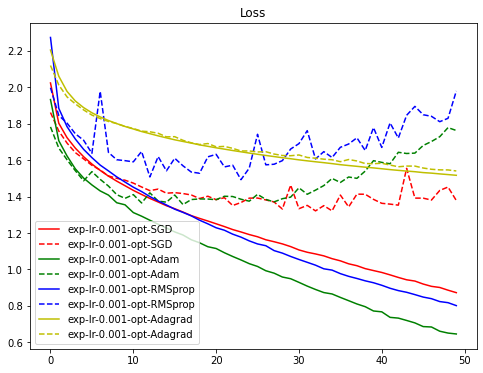

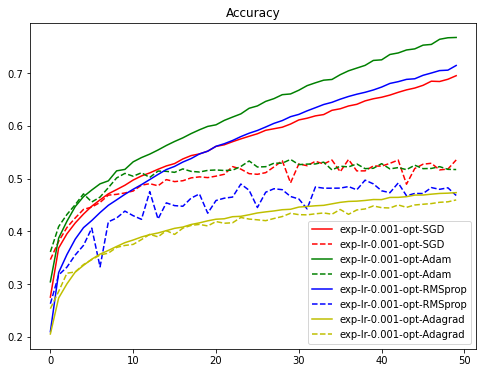

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "c", "p"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if 'exp-lr-0.001-' in cond: 
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i%8])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i%8])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if 'exp-lr-0.001-' in cond:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i%8])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i%8])
plt.title("Accuracy")
plt.legend()
plt.show()

In [21]:
for k in results.keys():
  if 'exp-lr-0.001-' in k:
    print(k)

exp-lr-0.001-opt-SGD
exp-lr-0.001-opt-Adam
exp-lr-0.001-opt-RMSprop
exp-lr-0.001-opt-Adagrad


### 觀察結果: 以learning rate= 0.001來看: Adam及SGD優化器accuracy表現相對較好

In [39]:
for k in results.keys():
  if 'exp-lr-0.001-' in k:
    print(results[k]['valid-acc'])

[0.3465000092983246, 0.38119998574256897, 0.4074000120162964, 0.4255000054836273, 0.4417000114917755, 0.44620001316070557, 0.45489999651908875, 0.46880000829696655, 0.47029998898506165, 0.47290000319480896, 0.4765999913215637, 0.4875999987125397, 0.49050000309944153, 0.48649999499320984, 0.498199999332428, 0.4943999946117401, 0.4961000084877014, 0.5015000104904175, 0.5034000277519226, 0.5019999742507935, 0.504800021648407, 0.5083000063896179, 0.5228999853134155, 0.5181000232696533, 0.5095000267028809, 0.5083000063896179, 0.5113999843597412, 0.5223000049591064, 0.5340999960899353, 0.492000013589859, 0.527899980545044, 0.5246000289916992, 0.5328999757766724, 0.527899980545044, 0.5353000164031982, 0.5131000280380249, 0.5364000201225281, 0.5146999955177307, 0.5148000121116638, 0.5241000056266785, 0.5236999988555908, 0.5291000008583069, 0.5353000164031982, 0.4894999861717224, 0.5192999839782715, 0.527400016784668, 0.52920001745224, 0.5166000127792358, 0.5181999802589417, 0.5354999899864197]